In [36]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import random
import utils

In [318]:
IMG_SIZE = 224

train_path = "resources\\dataset\\cont_training"
#train_path = "resources\\dataset\\training_set_small"

val_path = "resources\\dataset\\val_set"
test_path = "resources\\dataset\\test_set"

## Prepare train and test examples

In [319]:
def process(image,label):
    image = tf.cast((image/255.)*2-1 ,tf.float32)
    return image,label

In [320]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_path, labels='inferred', label_mode='int',
    color_mode='rgb', batch_size=64, image_size=(IMG_SIZE,
    IMG_SIZE), shuffle=True,
    interpolation='bilinear',
    subset = 'training',
    validation_split = 0.1,
    seed = 123
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_path, labels='inferred', label_mode='int',
    color_mode='rgb', batch_size=64, image_size=(IMG_SIZE,
    IMG_SIZE), shuffle=False,
    interpolation='bilinear',
)

train_ds = train_ds.map(process)
test_ds = test_ds.map(process)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 6224 files belonging to 2 classes.
Using 5602 files for training.
Found 105 files belonging to 2 classes.


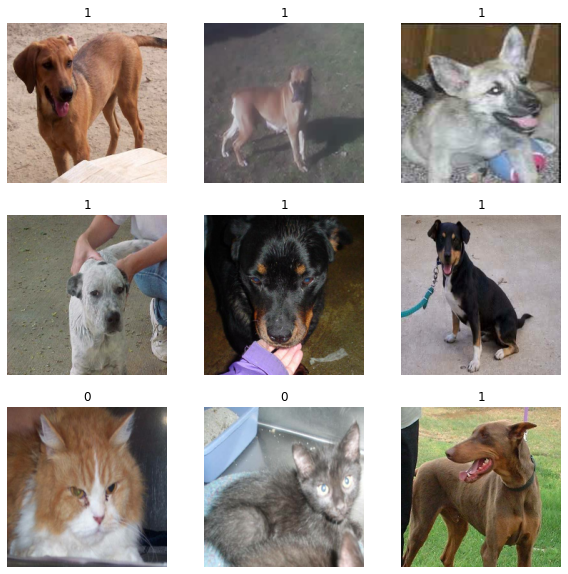

In [321]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy()/2+0.5)
        plt.title(int(labels[i]))
        plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


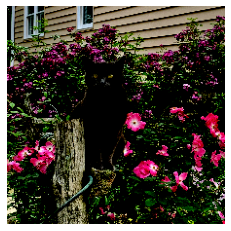

In [322]:
#plt.figure(figsize=(10, 10))
counter = 0
for images, labels in test_ds:
    for i in range(len(labels)):
        if (counter == 40):
            plt.imshow(images[i].numpy())
            plt.axis("off")
        counter += 1

In [47]:
a = datagen.as_numpy_iterator()

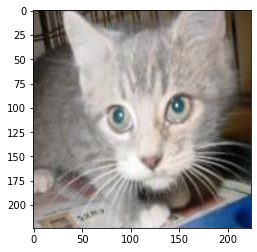

In [52]:
plt.imshow(a.next()[0][0]/255)

## Model

In [129]:
pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [244]:
pretrained_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [341]:
for layer in pretrained_model.layers:
    layer.trainable = False

In [342]:
x = tf.keras.layers.GlobalAveragePooling2D()(pretrained_model.output)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64, activation = "relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
#x = tf.keras.layers.Dense(256, activation = "relu")(x)
#x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(2, activation = "softmax")(x)
pretrained_with_top = tf.keras.Model(inputs = pretrained_model.input, outputs = outputs)

In [343]:
for i in pretrained_with_top.layers:
    print(i.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True


In [344]:
pretrained_with_top.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

## Training

In [345]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
pretrained_with_top.compile(optimizer = opt, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [346]:
class my_callback(tf.keras.callbacks.Callback):
    def on_batch_end(self, batch, logs=None):
        if (batch % 5 == 0):
            pretrained_with_top.evaluate(test_ds)
        return



In [349]:
tl_history = pretrained_with_top.fit(train_ds,
    epochs = 2, 
    validation_data = test_ds,
    callbacks=[my_callback()]
                                
                                    )

Epoch 1/2
88/88 [==============================] - 61s 694ms/step - loss: 0.0591 - accuracy: 0.9852 - val_loss: 0.1023 - val_accuracy: 0.9714
Epoch 2/2
88/88 [==============================] - 61s 700ms/step - loss: 0.0761 - accuracy: 0.9803 - val_loss: 0.1214 - val_accuracy: 0.9714


In [304]:
pretrained_with_top.evaluate(test_ds)

2/2 [==============================] - 1s 332ms/step - loss: 0.5226 - accuracy: 0.8952


[0.5226203203201294, 0.8952381014823914]

In [305]:
out

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [306]:
y_test = []
for images, batch_labels in test_ds:
    y_test += list(batch_labels.numpy())

In [307]:
out = pretrained_with_top.predict(test_ds)
out = np.argmax(out, axis = -1)

In [308]:
wrong = [i for i in zip(range(len(out)),out,y_test) if i[1] != i[2]]

In [309]:
wrong

[(0, 1, 0),
 (10, 1, 0),
 (14, 1, 0),
 (22, 1, 0),
 (28, 1, 0),
 (32, 1, 0),
 (39, 1, 0),
 (40, 1, 0),
 (41, 1, 0),
 (47, 1, 0),
 (48, 1, 0)]